# Анализ функций разладки

## Инициализация

In [1]:
from copy import deepcopy
import warnings

import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
import openpyxl
import pandas as pd
from utils.hmatr import Hmatr

from utils.modelling import modellingSeriesStatistics
from utils.modelling import fixSeriesStatistics

%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

warnings.filterwarnings('ignore')
rpy2.robjects.numpy2ri.activate()
# utils = importr('utils')

# utils.chooseCRANmirror(ind=1)
# utils.install_packages('Rssa')

rssa = importr('Rssa')

Unable to determine R home: [WinError 2] Не удается найти указанный файл
Unable to determine R library path: Command '('D:\\Program Files\\R\\R-4.1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/Rssa_1.0.4.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2218709 bytes (2.1 MB)

R[write to console]: downloaded 2.1 MB




package 'Rssa' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ivank\AppData\Local\Temp\RtmpYxpjtp\downloaded_packages


d:\education\magistracy\researchwork\researchwork\venv\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
N = 700
w1 = 1/10
w2 = 1/5
C1 = 1
C2 = 2
phi1 = 0
phi2 = np.pi/2
Q = 301  # 301 номер, значит разладка в ряде будет на 302й точке, если ряд задан с 0.
B = 100
T_ = 100
L = 50
r = 2
noiseVariance = 0.5


iterationsNumber = 300

method = "svd"

In [3]:
def plotSeries(s, title='Series', w=16, h=4):
    plt.figure(figsize=(w, h))
    plt.title(title)
    plt.plot(s)

Зададим наши функции

In [4]:
seriesPermanent = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w2*n + phi1)
seriesTemporary = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C2*np.sin(2*np.pi*w1*n + phi1)
seriesShifted = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w1*n + phi2)
seriesOutlier = lambda n: C1*np.sin(2*np.pi*w1*n + phi1)

Сгенерируем ряды с шумомом и без

In [5]:
np.random.seed(0)
eps = np.random.normal(scale=noiseVariance, size=N)

fPerm = [seriesPermanent(i) for i in range(N)]
fPermNoise = fPerm + eps

fTemp = [seriesTemporary(i) for i in range(N)]
tmp = deepcopy(eps)
tmp[:Q] = tmp[:Q]/2
fTempNoise = fTemp + tmp

fShifted = [seriesShifted(i) for i in range(N)]
fShiftedNoise = fShifted + eps


fOutlier = [seriesOutlier(i) for i in range(N)]
fOutlier[Q] = fOutlier[Q] + C1*10
fOutlierNoise = fOutlier + eps

---

# Определение качества функций разладки

## Ряды без шума

Посмотрим какая из функций разладок обладает наисильнейшей способностью определять неоднородность.  
Будем руководствоваться точкой обнаружения и скоростью возрастания. Для рядов без шума будем считать точкой обнаружения ту, значения функций обнаружения разладок которых становится отличной от нуля.

In [6]:
from utils.modelling import find_points_whith_non_zero_value


find_points_whith_non_zero_value(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    destFile='tables/results.xlsx',
    title='withoutNoise(Zeros)',
)
res = pd.read_excel('tables/results.xlsx', sheet_name='withoutNoise(Zeros)', engine='openpyxl')
res.fillna(' ', inplace=True)
res

,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Row,ZeroValue,,Col,ZeroValue,,Sym,ZeroValue,,Diag,ZeroValue
1,detected Q,302,,detected Q,302,,detected Q,302,,detected Q,302
2,X[Q],0,,X[Q],0,,X[Q],0,,X[Q],0
3,X[Q+10],0.0427948,,X[Q+10],0.00281497,,X[Q+10],0.0401788,,X[Q+10],0.0427948
4,X[Q+20],0.146766,,X[Q+20],0.0139947,,X[Q+20],0.135379,,X[Q+20],0.146766
5,X[Q+30],0.296227,,X[Q+30],0.0385181,,X[Q+30],0.270609,,X[Q+30],0.296227
6,,,,,,,,,,,
7,,,,,,,,,,,
8,Temporary,,,,,,,,,,
9,Row,ZeroValue,,Col,ZeroValue,,Sym,ZeroValue,,Diag,ZeroValue


В таблице выше привидены рассчитаные статистики функций разладок для разных типов неоднородностей. Сделаем выводы по данной таблице.  
* `Постоянная разладка`: Все функции обнаружили разладку в одной точке - следующей после известной нам точкой возмущения. Задержка составила одно значение. Однако с точки зрения скорости возрастания, как и величины возрастания, фаворитами являются *строковая* и *диагональная* функции обнаружения.
* `Временная разладка (изменение амплитуды)`: Здесь аналогичная ситуация.
* `Временная разладка (фазовый сдвиг)`: Неоднородность, вызванная фазовым сдвигом определяется сразу в той же точке, в которой и была задана точка возмущения. В функциях обнаружения видим аналогичную картину.
* `Временная разладка (выброс)`: Фаворитами опять же являются *строковая* и *диагональная*.

### Анализ изменений функций разладки при разных значениях параметров ряда

Посмотрим на графики строковых функций разладки в случае *постоянной* разладки при разных значениях частот ряда.

In [6]:
def generate_series(omega, C1=1, C2=2, outlierVal=10, N=700, Q=301):
    w1, w2 = omega
    seriesPermanent = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w2*n + phi1)
    seriesTemporary = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C2*np.sin(2*np.pi*w1*n + phi1)
    seriesShifted = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w1*n + phi2)
    seriesOutlier = lambda n: C1*np.sin(2*np.pi*w1*n + phi1)
    
    fPerm = [seriesPermanent(i) for i in range(N)]
    fTemp = [seriesTemporary(i) for i in range(N)]
    fShifted = [seriesShifted(i) for i in range(N)]
    fOutlier = [seriesOutlier(i) for i in range(N)]
    fOutlier[Q] = fOutlier[Q] + C1*outlierVal
    return dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier]))

def generate_hm_for_series(dictSeries, which):
    dictHM = {}
    for typeH, valH in zip(dictSeries.keys(), dictSeries.values()):
        if typeH not in which:
            continue
        dictHM[typeH] = Hmatr(valH, B, T_, L, neig=r, svdMethod=method)
    return dictHM

def get_det_func(dictHM, which):
    dictHMFunc = {}
    for typeHM, HM in zip(dictHM.keys(), dictHM.values()):
        dictFunc = {}
        for func in which:
            if func == 'row':
                dictFunc[func] = HM.getRow()
            if func == 'col':
                dictFunc[func] = HM.getCol()
            if func == 'sym':
                dictFunc[func] = HM.getSym()
            if func == 'diag':
                dictFunc[func] = HM.getDiag()
        dictHMFunc[typeHM] = dictFunc
    return dictHMFunc

def generate_funcs_for_diff_omegas(omegas, whichH, whichF):
    ans = {}
    for omega in omegas:
        ans[str(omega)] = get_det_func(generate_hm_for_series(generate_series(omega), whichH), whichF)
    return ans

def plot_heter_func(freqStats, which):
    
    len_types_hm = len(freqStats[list(freqStats.keys())[0]].keys())
    len_types_func = len(which)
    plt.figure(figsize=(10 * len_types_func, 6 * len_types_hm))
    for omegas, heterogeneity in zip(freqStats.keys(), freqStats.values()):
        for i, (typeH, funcs) in enumerate(zip(heterogeneity.keys(), heterogeneity.values())):
            for j, (typeF, vals) in enumerate(zip(funcs.keys(), funcs.values())):
                plt.subplot(len_types_hm, len_types_func, i * 4 + j + 1)
                plt.plot(vals, label = omegas)
                plt.title(f"{typeH} - {typeF}")
                plt.xlabel(r"$x_i$")
                plt.ylabel(r"$f(x_i)$")
                plt.ylim(0, 1)
                plt.legend()
    plt.show()

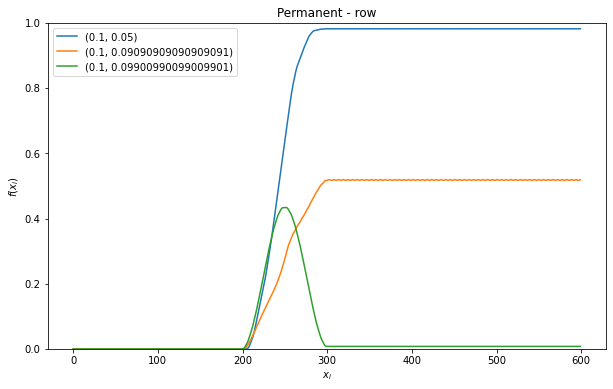

In [22]:
which_heterogeneity = ['Permanent']
which_funcs = ['row']
omegas = ((1/10, 1/20), (1/10, 1/11), (1/10, 1/10.1))
plot_heter_func(generate_funcs_for_diff_omegas(omegas, which_heterogeneity, which_funcs), which_funcs)

Проверим еще раз.

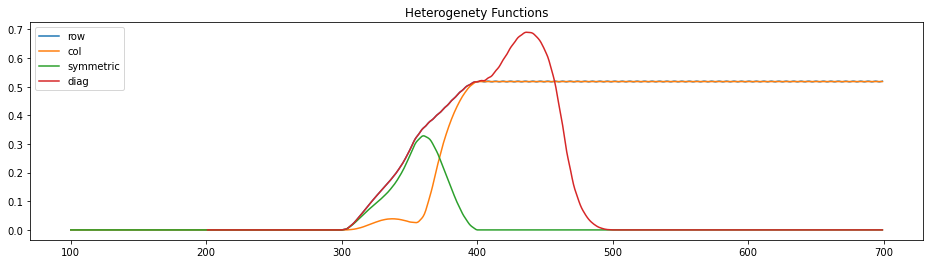

In [9]:
generate_hm_for_series(generate_series((1/10, 1/11)), which_heterogeneity)['Permanent'].plotHeterFunc()

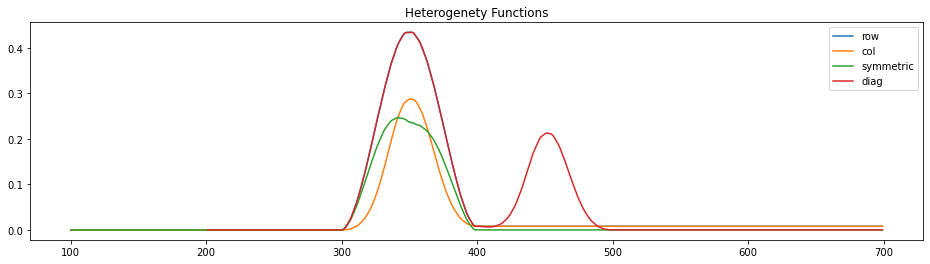

In [10]:
tmp = generate_hm_for_series(generate_series((1/10, 1/10.1)), which_heterogeneity)['Permanent'].plotHeterFunc()

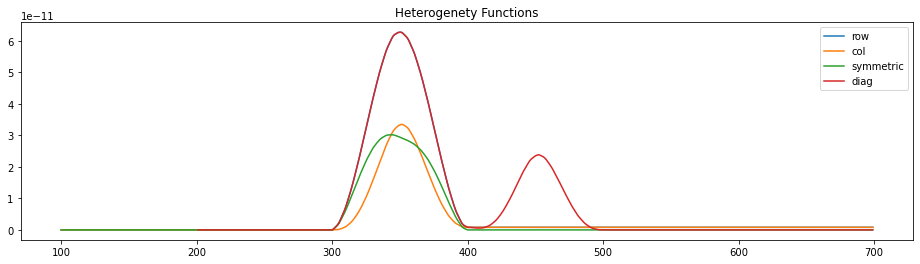

In [11]:
tmp = generate_hm_for_series(generate_series((1/10, 1/10.000001)), which_heterogeneity)
tmp['Permanent'].plotHeterFunc()

Из эмпирических наблюдений следует вывод:  
**Чем сильнее различия в рядах, тем лучше метод определяет наличие неоднородности**.
  
Наблюдая за графиками, видим что в большинстве комбинаций частот, в отличии от диагональной, строковая функция обнаружения, после возмущения, остается в значениях около 1.

---

## Ряды с шумом

В случае рядов с шумом из-за случайной составляющей для получения статистик функций разладки нужно все значения моделировать методом Монте-Карло и, к примеру, брать среднее, и на основе полученных значений попытаться сделать какие-либо выводы.

### Моделирования статистик шума

Промоделируем статистики шума - средний максимум и средний 95-й процентиль на участке $ [0, Q-t] $, где $ t $ - tail, длина базового/тестового окна в зависимости от типа функции разладки. 

In [12]:
from utils.modelling import modellingNoiseStatistics

?modellingNoiseStatistics

Signature:
modellingNoiseStatistics(
    dictSeries:dict,
    iterNum:int,
    N:int,
    B:int,
    T:int,
    Q:int,
    L:int,
    r:int,
    method:str,
    vareps:float,
)
Docstring:
Моделирование статистик ряда (средний 95й процентиль и средний максимум) при различных реализациях шума до момента разладки методом Монте-Карло.
Внимание, шум добавляется внутри метода!
:param dict dictSeries: The dictionary where key is the type of series and value is a series. Example: { 'Permanent': [x_1, ..., x_N] }.
:param int iterNum: Number of iterations for modelling.
:param int N: The len of series.
:param int B: The len of base subseries.
:param int T: The len of test subseries.
:param int Q: The point of perturbation.
:param int L: The window len.
:param int r: Number of eigen vectors.
:param str method: SVD method.
:param float vareps: Variance of the noise.
:return: Pandas DataFrame
File:      f:\users\ivank\documents\education\magistracy\researchwork\researchwork\utils\modelling.py
Type:

In [13]:
%%time
dictSeries = dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier]))
statistics = modellingNoiseStatistics(dictSeries, iterationsNumber+100, N, B, T_, Q, L, r, method, noiseVariance)
statistics.to_csv("tables/modelledStatistics.csv", index=False)
pd.read_csv("tables/modelledStatistics.csv")

Wall time: 56min 14s


,HeterType,StatType,row,col,sym,diag
0,Permanent,meanMax,0.131805,0.111598,0.129039,0.124448
1,Permanent,mean95Procentile,0.129611,0.111132,0.126633,0.123187
2,Temporary,meanMax,0.035768,0.030365,0.035017,0.033929
3,Temporary,mean95Procentile,0.035180,0.030242,0.034375,0.033541
4,Shifted,meanMax,0.133104,0.112531,0.130376,0.124902
5,Shifted,mean95Procentile,0.131274,0.112053,0.128347,0.123537
6,Outlier,meanMax,0.131733,0.111314,0.128759,0.124699
7,Outlier,mean95Procentile,0.129673,0.110872,0.126534,0.123212


---

## Промоделированные значения

Для начала нужно определиться с точкой начала возрастания. Из-за шума значения функций разладки в промежутке $ [0, Q-1] $ будут смещены выше, а значит подход, при котором первое значение наших функции отличны от $ 0 $ не подойдет. Вооружимся двумя статистиками, а именно средним максимумом и средним 95-м процентилем значений ряда на промежутке $ [0, Q-1] $.

In [46]:
from utils.coop_modelling import modelling_series_statistics

In [64]:
%%time
confidence_intervals = \
    modelling_series_statistics(
        dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
        iterNum=1,
        N=N,
        B=B,
        T=T_,
        Q=Q,
        L=L,
        r=r,
        method=method,
        destFile='tables/results.xlsx',
        title='withNoise',
        vareps=noiseVariance
    )

fixedResult = pd.read_excel('tables/results.xlsx', sheet_name='withNoise', engine='openpyxl', usecols=range(18))
fixedResult.fillna(' ', inplace=True)
fixedResult[:40]

CPU times: total: 5.41 s
Wall time: 5.47 s


In [61]:
pd.DataFrame(confidence_intervals['Permanent'])

,mean_max,95
Row,"{'overc_p': [313.8982282507981, 316.1017717492...","{'overc_p': [313.8982282507981, 316.1017717492..."
Col,"{'overc_p': [315.82610632425514, 319.573893675...","{'overc_p': [315.82610632425514, 319.573893675..."
Sym,"{'overc_p': [314.7862643701478, 317.0137356298...","{'overc_p': [314.7862643701478, 317.0137356298..."
Diag,"{'overc_p': [309.84363403841746, 312.356365961...","{'overc_p': [309.84363403841746, 312.356365961..."


In [15]:
%%time
modellingSeriesStatistics(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
    iterNum=iterationsNumber,
    N=N,
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    destFile='tables/results.xlsx',
    modellingResultsPath = 'tables/modelledStatistics.csv',
    title='withNoise',
    vareps=noiseVariance
)

fixedResult = pd.read_excel('tables/results.xlsx', sheet_name='withNoise', engine='openpyxl', usecols=range(18))
fixedResult.fillna(' ', inplace=True)
fixedResult[:40]

Wall time: 42min 35s


,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Row,meanMax,95 procentile,,,Col,meanMax,95 procentile,,,Sym,meanMax,95 procentile,,,Diag,meanMax,95 procentile
1,Num Points of overcoming,300,300,,,Num Points of overcoming,300,300,,,Num Points of overcoming,300,300,,,Num Points of overcoming,300,300
2,detected Q,251,243,,,detected Q,226,222,,,detected Q,250,241,,,detected Q,272,269
3,X[detected Q],0.133627,0.131588,,,X[detected Q],0.115613,0.115283,,,X[detected Q],0.131059,0.128728,,,X[detected Q],0.127891,0.126824
4,X[Q],0.109274,0.109274,,,X[Q],0.106858,0.106858,,,X[Q],0.106532,0.106532,,,X[Q],0.109433,0.109433
5,X[Q+10],0.147138,0.147138,,,X[Q+10],0.109407,0.109407,,,X[Q+10],0.142165,0.142165,,,X[Q+10],0.147287,0.147287
6,X[Q+20],0.238999,0.238999,,,X[Q+20],0.119862,0.119862,,,X[Q+20],0.226143,0.226143,,,X[Q+20],0.238914,0.238914
7,X[Q+30],0.370755,0.370755,,,X[Q+30],0.14262,0.14262,,,X[Q+30],0.345101,0.345101,,,X[Q+30],0.370505,0.370505
8,,,,,,,,,,,,,,,,,,
9,Temporary,,,,,,,,,,,,,,,,,


# Нужно что-то более устойчивое. МБ взять сумму среднего максимума и среднего 95-го процентиля...

Выделим количество `Num Points of overcoming` отдельно.

In [16]:
def get_num_points_of_overcome(data):
    return {
        "Row": [data.iat[i, j] for i in range(1, 32, 10) for j in range(1, 3)],
        "Col": [data.iat[i, j] for i in range(1, 32, 10) for j in range(6, 8)],
        "Sym": [data.iat[i, j] for i in range(1, 32, 10) for j in range(11, 13)], 
        "Diag": [data.iat[i, j] for i in range(1, 32, 10) for j in range(16, 18)],
    }

def create_df_poc(data):
    res = get_num_points_of_overcome(data)
    ds = pd.DataFrame(columns=["HeterType", "StatType", "row", "col", "sym", "diag"])
    ds["HeterType"] = ['Permanent', 'Permanent', 'Temporary', 'Temporary', 'Shifted', 'Shifted', 'Outlier', 'Outlier']
    ds["StatType"] = ["meanMax", "mean95Procentile"]*4
    ds["row"] = res["Row"]
    ds["col"] = res["Col"]
    ds["sym"] = res["Sym"]
    ds["diag"] = res["Diag"]
    return ds

In [17]:
fixedResult = pd.read_excel('tables/results.xlsx', sheet_name='withNoise', engine='openpyxl', usecols=range(18))
fixedResult.fillna(' ', inplace=True)
ds = create_df_poc(fixedResult)
ds[ds.columns[-4:]].astype(int)
ds

,HeterType,StatType,row,col,sym,diag
0,Permanent,meanMax,300,300,300,300
1,Permanent,mean95Procentile,300,300,300,300
2,Temporary,meanMax,300,300,300,300
3,Temporary,mean95Procentile,300,300,300,300
4,Shifted,meanMax,300,300,300,300
5,Shifted,mean95Procentile,300,300,300,300
6,Outlier,meanMax,300,295,300,300
7,Outlier,mean95Procentile,300,295,300,300


Посмотрим на процент преодоления промоделированных значений.

In [18]:
ds[ds.columns[-4:]] = ds[ds.columns[-4:]]/iterationsNumber*100
ds

,HeterType,StatType,row,col,sym,diag
0,Permanent,meanMax,100.0,100.000000,100.0,100.0
1,Permanent,mean95Procentile,100.0,100.000000,100.0,100.0
2,Temporary,meanMax,100.0,100.000000,100.0,100.0
3,Temporary,mean95Procentile,100.0,100.000000,100.0,100.0
4,Shifted,meanMax,100.0,100.000000,100.0,100.0
5,Shifted,mean95Procentile,100.0,100.000000,100.0,100.0
6,Outlier,meanMax,100.0,98.333333,100.0,100.0
7,Outlier,mean95Procentile,100.0,98.333333,100.0,100.0


### Анализ изменений функций разладки при разных значениях параметров ряда

Проведем такое же моделирование, как и выше, но только для постоянной разладки при изменении частот рядов.

In [19]:
def start_testing(omegas, iterNum=200):
    for omega in omegas:
        print("Processing ", omega)
        modellingSeriesStatistics(
            dictSeries=generate_series(omega),
            iterNum=iterNum,
            N=N,
            B=B,
            T=T_,
            Q=Q,
            L=L,
            r=r,
            method=method,
            destFile='tables/resultsModelling.xlsx',
            modellingResultsPath = 'tables/modelledStatistics.csv',
            title=str(omega),
            vareps=noiseVariance
        )    

In [20]:
%%time
omegas = ((1/10, 1/1000), (1/10, 1/20), (1/10, 1/11), (1/10, 1/10.1), (1/10, 1/10.001))
start_testing(omegas, iterationsNumber)

Processing  (0.1, 0.001)
Processing  (0.1, 0.05)
Processing  (0.1, 0.09090909090909091)
Processing  (0.1, 0.09900990099009901)
Processing  (0.1, 0.09999000099990002)
Wall time: 3h 33min 11s


---

# Анализ переходного интервала (численный)

In [87]:
import warnings
warnings.filterwarnings('ignore')

from utils.hmatrStatistics import Hmatr

In [105]:
L=50
hm = Hmatr(fPerm, B, T_, L, neig=r, svdMethod=method)
data = hm.compute_distance(0)
print(np.sum(data[220], axis=1))
data[251]

[1094.873311 1250.      ]


array([[2.5000000e+01, 2.5432330e+01, 2.4738084e+01, 2.1928115e+01,
        2.0394721e+01, 2.0394721e+01, 1.8671885e+01, 1.6213162e+01,
        1.5663638e+01, 1.6000000e+01, 1.6000000e+01, 1.6346919e+01,
        1.5790871e+01, 1.3566312e+01, 1.2394721e+01, 1.2394721e+01,
        1.1033688e+01, 9.1603750e+00, 8.7490480e+00, 9.0000000e+00,
        9.0000000e+00, 9.2615090e+00, 8.8436570e+00, 7.2045080e+00,
        6.3947210e+00, 6.3947210e+00, 5.3954920e+00, 4.1075890e+00,
        3.8344580e+00, 4.0000000e+00, 4.0000000e+00, 4.1760990e+00,
        3.8964430e+00, 2.8427050e+00, 2.3947210e+00, 2.3947210e+00,
        1.7572950e+00, 1.0548030e+00, 9.1986800e-01, 1.0000000e+00,
        1.0000000e+00, 1.0906890e+00, 9.4923000e-01, 4.8090200e-01,
        3.9472100e-01, 3.9472100e-01, 1.1909800e-01, 2.0160000e-03,
        5.2790000e-03, 0.0000000e+00],
       [2.5000000e+01, 2.5559017e+01, 2.5000000e+01, 2.4440983e+01,
        2.5000000e+01, 2.5000000e+01, 2.5559017e+01, 2.5000000e+01,
        2

In [94]:
L=10
hm = Hmatr(fPerm, B, T_, L, neig=r, svdMethod=method)
data = hm.compute_distance(0)
print(np.sum(data[220], axis=1))
data[220]

[377.183281 450.      ]


array([[5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.453444, 4.746149, 2.404508, 1.973607, 1.973607, 0.595492,
        0.010081, 0.026393, 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 

In [96]:
data[240]

array([[5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.      , 5.      ,
        5.      , 5.      , 5.      , 5.      , 5.453444, 4.746149,
        2.404508, 1.973607, 1.973607, 0.595492, 0.010081, 0.026393,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 

In [99]:
L=90
hm = Hmatr(fPerm, B, T_, L, neig=r, svdMethod=method)
data = hm.compute_distance(0)
print(np.sum(data[220], axis=1))
data[211]

[321.909255 450.      ]


array([[45.      , 45.429984, 44.737188, 41.875183, 40.21929 , 40.21929 ,
        38.458151, 35.791282, 35.178887, 35.555556],
       [45.      , 45.559017, 45.      , 44.440983, 45.      , 45.      ,
        45.559017, 45.      , 44.440983, 45.      ]])

In [100]:
data[221]

array([[35.555556, 35.938089, 35.322069, 32.785292, 31.330401, 31.330401,
        29.770264, 27.428623, 26.893004, 27.222222],
       [45.      , 45.559017, 45.      , 44.440983, 45.      , 45.      ,
        45.559017, 45.      , 44.440983, 45.      ]])

In [101]:
data[231]

array([[27.222222, 27.557306, 27.018062, 24.806512, 23.552623, 23.552623,
        22.193488, 20.177075, 19.718232, 20.      ],
       [45.      , 45.559017, 45.      , 44.440983, 45.      , 45.      ,
        45.559017, 45.      , 44.440983, 45.      ]])

In [102]:
data[241]

array([[20.      , 20.287633, 19.825165, 17.938844, 16.885956, 16.885956,
        15.727823, 14.036638, 13.654571, 13.888889],
       [45.      , 45.559017, 45.      , 44.440983, 45.      , 45.      ,
        45.559017, 45.      , 44.440983, 45.      ]])